# Statistics notebook: Shared States
Accompanying the manuscript "Shared states: Using MVPA to test neural overlap between self-focused emotion imagery and other-focused emotion understanding" (Oosterwijk, Snoek, Rotteveel, Barrett, & Scholte, submitted)

Lukas Snoek, February 2016 | lukassnoek@gmail.com <br>
https://github.com/lukassnoek/DecodingEmotions

In [1]:
from __future__ import division, print_function
import cPickle
import os
import glob
import os.path as op
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The function below transforms 'raw' confusion matrics (in which the numbers indicate the number of trials assigned to a particular class, with the x-axis referring to the predicted class and the y-axis referring to the true class). The metrics precision (also known as Positive Predictive Value), recall (also known as the True Positive Rate), and F1-score (harmonic mean between precision and recall) are supported. In the article, precision-scores are reported.

In [2]:
def compute_score_confmat(confmat, metric='precision'):
    
    if metric == 'precision':
        return confmat / confmat.sum(axis=0)
    elif metric == 'recall':
        return confmat / confmat.sum(axis=1)
    elif metric == 'F1':
        precision = confmat / confmat.sum(axis=0)
        recall = confmat / confmat.sum(axis=1)
        return 2 * (recall * precision) / (recall + precision)               

In [3]:
# Location of results from 100,000 iterations analysis
self_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_zinnen/100000iter_results'
other_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/100000iter_results'

### Statistics of self-analysis
Below, we load in the subject-specific confusion matrices and convert the 'raw' metrics to more easily interpretable 'precision' scores:

$$ precision = \frac{true positives}{true positives + false positives} $$

The resulting ndarray thus contains precision-matrices for each subject, of which the average is plotted below.

In [5]:
self_files = glob.glob(op.join(self_dir, '*.pickle'))
s_confmat = np.zeros((len(self_files), 3, 3))
for i, f in enumerate(self_files):
    tmp = cPickle.load(open(f)).conf_mat
    s_confmat[i, :, :] = compute_score_confmat(tmp, metric='precision')

s_confmat[np.isnan(s_confmat)] = 0

TypeError: __init__() got an unexpected keyword argument 'fontsize'

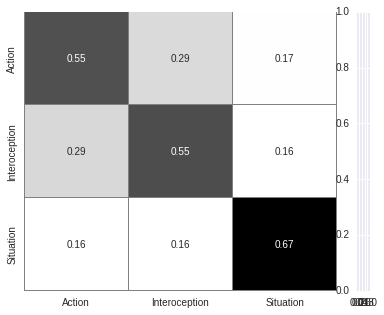

In [38]:
labels = ['Action', 'Interoception', 'Situation']
s_av_cm = s_confmat.mean(axis=0)
plt.figure(figsize=(7,5))
ax = sns.heatmap(s_av_cm, cmap=plt.cm.Greys, annot=True, xticklabels=labels, yticklabels=labels,
            linewidths=0.1, linecolor='grey', cbar_kws={'label': 'test', 'fontsize': 15})
plt.xlabel('Actual class')
plt.ylabel('Predicted class')
plt.tight_layout()
plt.savefig('self.png')

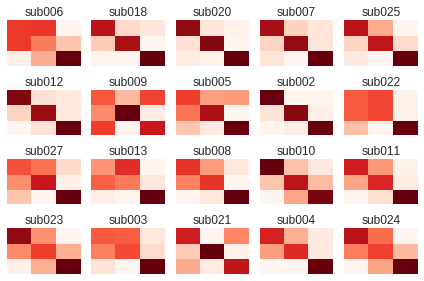

In [371]:
plt.subplots(4, 5)
for i in range(n):
    plt.subplot(4, 5, i+1)
    sns.heatmap(s_confmat[i,:,:], cmap=plt.cm.Reds, cbar=False,
                linewidths=0, linecolor='grey',
                xticklabels=False, yticklabels=False)
    plt.title(op.basename(self_files[i]).split('_')[0])
plt.tight_layout()

In [11]:
n = s_confmat.shape[0]
tmat = (s_confmat.mean(axis=0) - 0.333) / (s_confmat.std(axis=0) / np.sqrt(n-1))
pmat = np.array([np.round(stats.t.sf(np.abs(tt), n-1)*2, 3) for tt in tmat])

## Statistics of cross-analysis

In [8]:
other_files = glob.glob(op.join(other_dir, '*.pickle'))
o_confmat = np.zeros((len(other_files), 3, 3))
for i, f in enumerate(other_files):
    tmp = cPickle.load(open(f)).conf_mat
    o_confmat[i, :, :] = compute_score_confmat(tmp, metric='recall')
o_confmat[np.isnan(o_confmat)] = 0

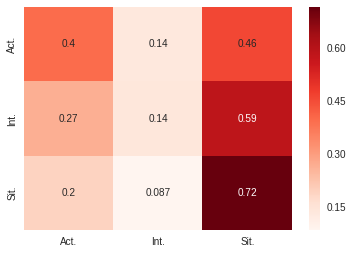

In [9]:
labels = ['Act.', 'Int.', 'Sit.']
o_av_cm = o_confmat.mean(axis=0)
hm = sns.heatmap(o_av_cm, cmap=plt.cm.Reds, annot=True, xticklabels=labels, yticklabels=labels,
            linewidths=0, linecolor='grey')

hm.figure.savefig('cross_confmat.png')

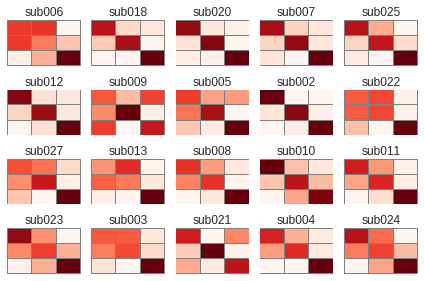

In [379]:
plt.subplots(4, 5)
for i in range(n):
    plt.subplot(4, 5, i+1)
    sns.heatmap(s_confmat[i,:,:], cmap=plt.cm.Reds, cbar=False,
                linewidths=.1, linecolor='grey',
                xticklabels=False, yticklabels=False)
    plt.title(op.basename(self_files[i]).split('_')[0])
plt.tight_layout()

In [382]:
n = s_confmat.shape[0]
tmat = (o_confmat.mean(axis=0) - 0.333) / (o_confmat.std(axis=0) / np.sqrt(n-1))
pmat = np.array([np.round(stats.t.sf(np.abs(tt), n-1)*2, 3) for tt in tmat])

### Permutation statistics

In [14]:
perm_dir = '/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/'
dirs = glob.glob(op.join(perm_dir, 'perm_*'))

perm_mats = np.zeros((len(dirs), n, 3, 3))

for i, d in enumerate(dirs):
    print(d)
    mats = glob.glob(op.join(d, '*confmat.npy'))
    
    for ii, m in enumerate(mats):
        perm_mats[i, ii, :, :] = np.load(m)

perm_mats = perm_mats / np.expand_dims(perm_mats.sum(axis=2), -1)

/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_1061
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_1216
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_420
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_533
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_212
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_448
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_1345
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_528
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_395
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_487
/media/lukas/data/DecodingEmotions/Validation_set/glm_HWW/permutation_results/perm_1059
/media/lukas/data/DecodingEmotions/Vali

In [15]:
av_perm_mats = perm_mats.mean(axis=1)
np.round((o_confmat.mean(axis=0) < av_perm_mats).sum(axis=0) / av_perm_mats.shape[0], 3)

array([[ 0.   ,  1.   ,  0.082],
       [ 0.998,  1.   ,  0.005],
       [ 1.   ,  1.   ,  0.   ]])